# UTD-MHAD Pose ↔ IMU alignment QA

Visualize standardized accelerometer clips alongside aligned skeleton signals to ensure synchronized lengths.

In [1]:
from pathlib import Path
import numpy as np
import random
import matplotlib.pyplot as plt
import yaml

DATA_ROOT = (Path.cwd() / '../datasets' / 'UTD_MHAD').resolve()
CONFIG_PATH = (Path.cwd() / '../conf' / 'data' / 'mhad.yaml').resolve()
print('Data root:', DATA_ROOT)
assert DATA_ROOT.exists(), 'Missing dataset dir'
with CONFIG_PATH.open('r') as f:
    cfg = yaml.safe_load(f) or {}
TRAIN_SUBJECTS = cfg.get('train_subjects', [])
print('Train subjects:', TRAIN_SUBJECTS)

Data root: /Users/parham/Desktop/The Semester/code/datasets/UTD_MHAD
Train subjects: ['s1', 's2', 's3', 's4']


In [2]:
def collect_pairs(subjects):
    pairs = []
    for subject in subjects:
        subj_dir = DATA_ROOT / subject
        if not subj_dir.is_dir():
            continue
        for std_path in sorted(subj_dir.glob(f'a*_{subject}_t*_inertial_std.npy')):
            prefix = std_path.name.replace('_inertial_std.npy', '')
            skel_aligned = subj_dir / f"{prefix}_skeleton_aligned.npy"
            skel_norm = subj_dir / f"{prefix}_skeleton_norm.npy"
            if skel_aligned.exists() and skel_norm.exists():
                pairs.append((std_path, skel_aligned, skel_norm))
    return pairs

subjects = TRAIN_SUBJECTS if TRAIN_SUBJECTS else [d.name for d in DATA_ROOT.iterdir() if d.is_dir()]
pairs = collect_pairs(subjects)
print(f'Collected {len(pairs)} (IMU, pose aligned, pose norm) tuples.')

Collected 335 (IMU, pose aligned, pose norm) tuples.


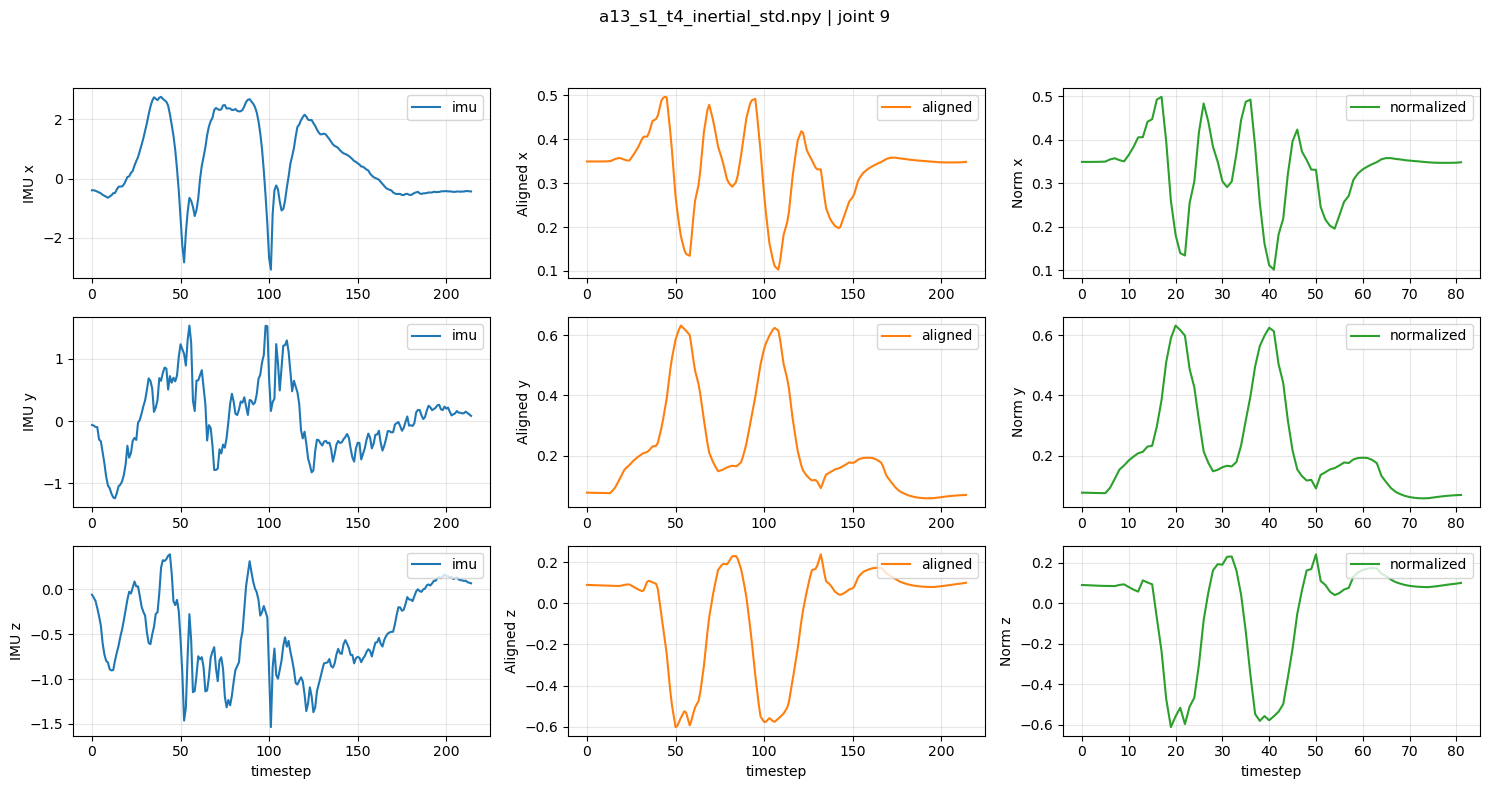

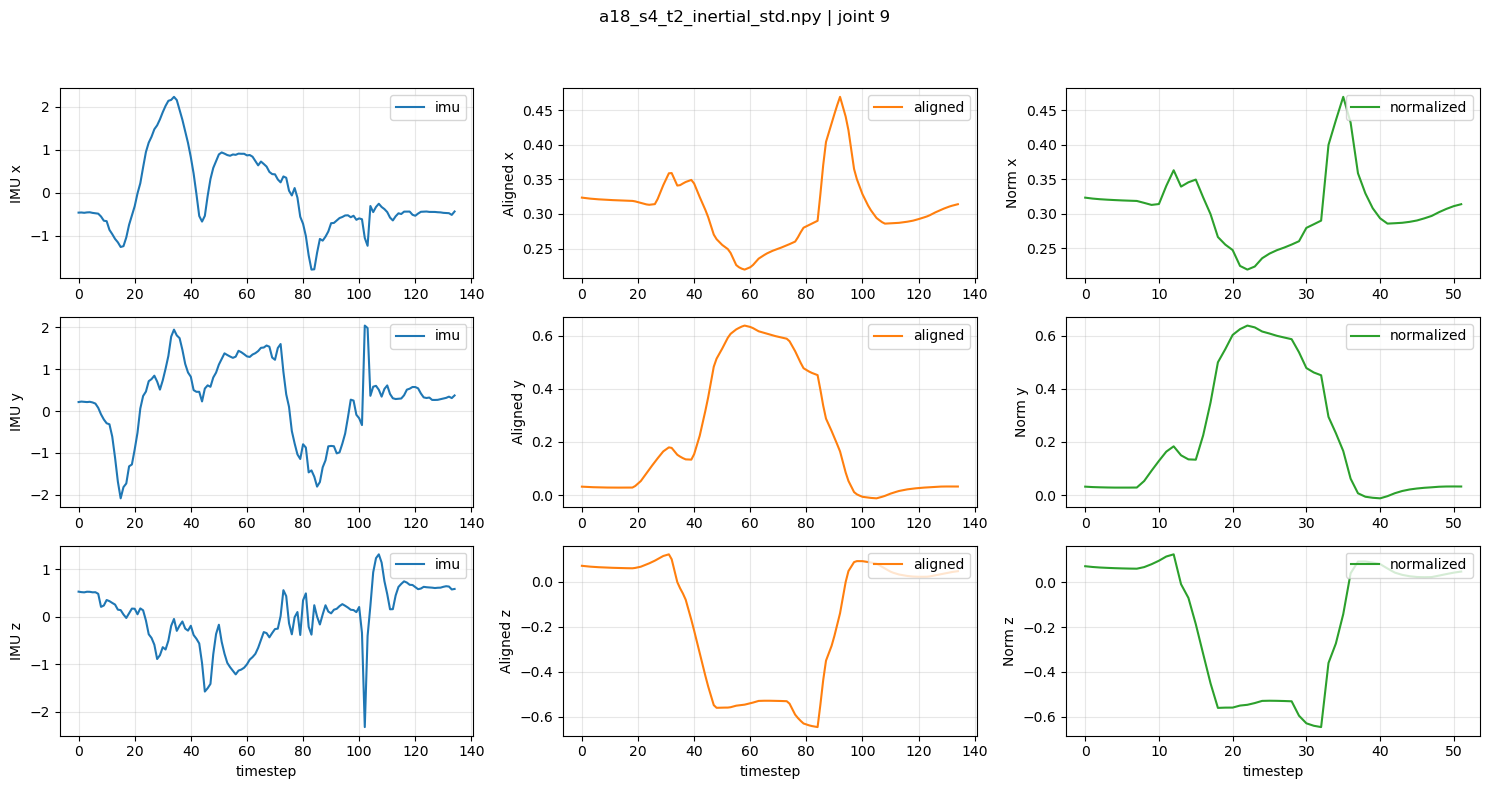

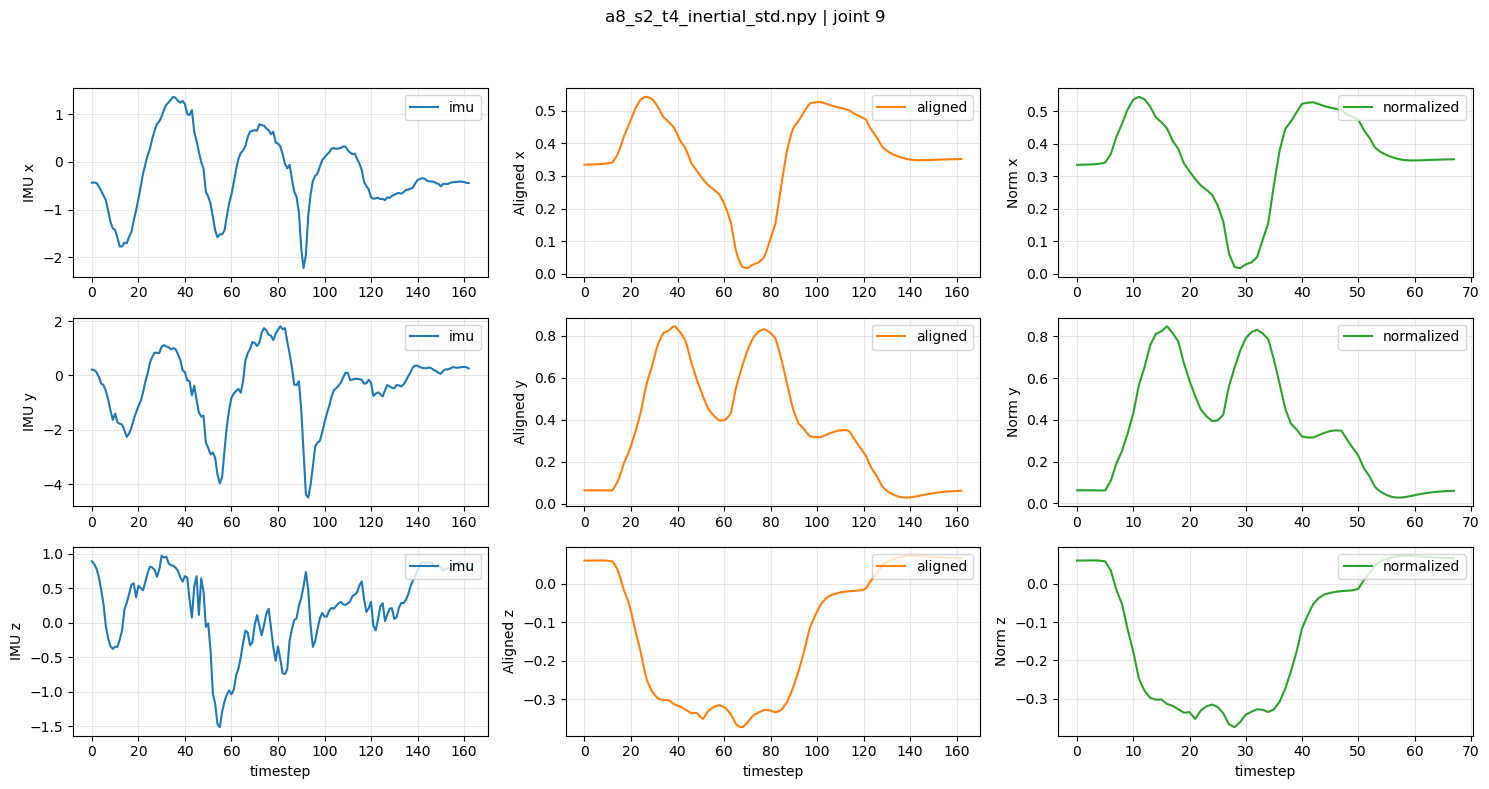

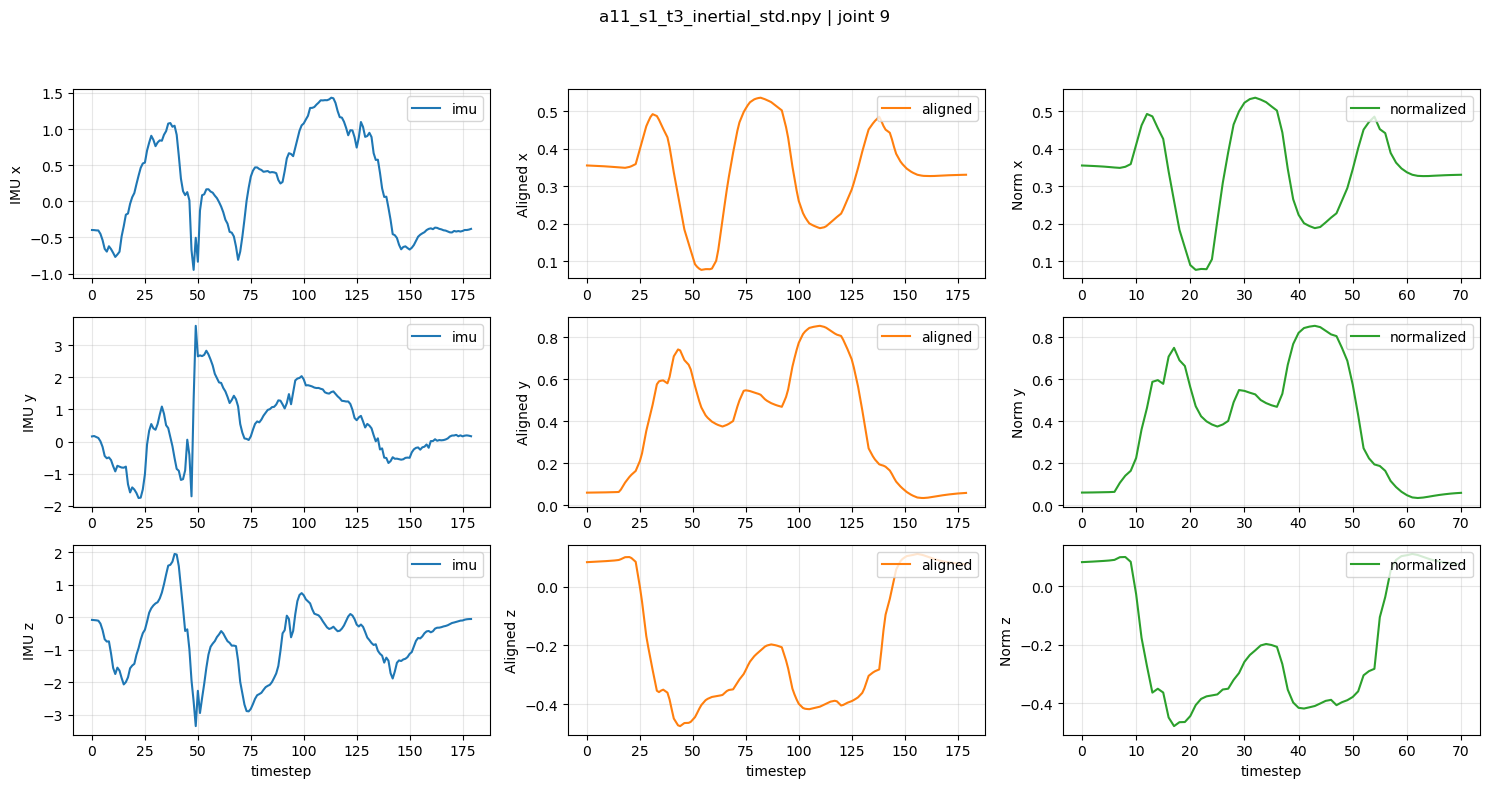

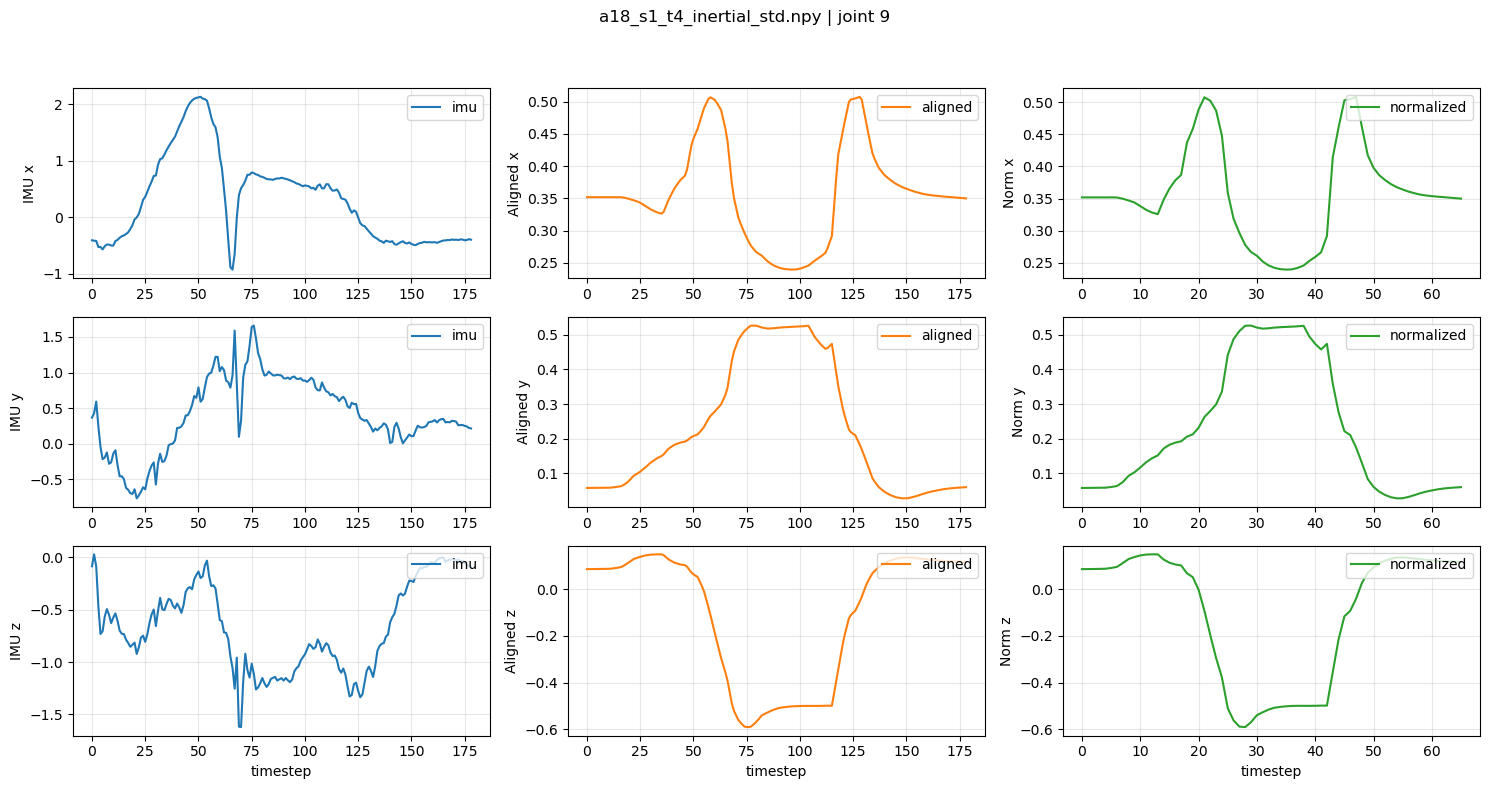

In [4]:
def load_acc(std_path: Path) -> np.ndarray:
    arr = np.load(std_path)
    if arr.ndim == 2 and arr.shape[0] != 3 and arr.shape[1] == 3:
        arr = arr.T
    return arr[:3, :]


def load_skel(path: Path) -> np.ndarray:
    arr = np.load(path)
    if arr.ndim == 3 and arr.shape[0] != 3:
        arr = arr[:3, :, :]
    return arr


def plot_pair(std_path: Path, aligned_path: Path, norm_path: Path, joint_idx: int = 8):
    acc = load_acc(std_path)
    skel_aligned = load_skel(aligned_path)
    skel_norm = load_skel(norm_path)
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    fig.suptitle(f'{std_path.name} | joint {joint_idx}')
    axes = ['x', 'y', 'z']
    for axis in range(3):
        axs[axis, 0].plot(np.arange(acc.shape[1]), acc[axis], color='tab:blue', label='imu')
        axs[axis, 0].set_ylabel(f'IMU {axes[axis]}')
        axs[axis, 0].grid(True, alpha=0.3)
        axs[axis, 0].legend(loc='upper right')
        axs[axis, 1].plot(np.arange(skel_aligned.shape[2]), skel_aligned[axis, joint_idx, :], color='tab:orange', label='aligned')
        axs[axis, 1].set_ylabel(f'Aligned {axes[axis]}')
        axs[axis, 1].grid(True, alpha=0.3)
        axs[axis, 1].legend(loc='upper right')
        axs[axis, 2].plot(np.arange(skel_norm.shape[2]), skel_norm[axis, joint_idx, :], color='tab:green', label='normalized')
        axs[axis, 2].set_ylabel(f'Norm {axes[axis]}')
        axs[axis, 2].grid(True, alpha=0.3)
        axs[axis, 2].legend(loc='upper right')
    axs[-1, 0].set_xlabel('timestep')
    axs[-1, 1].set_xlabel('timestep')
    axs[-1, 2].set_xlabel('timestep')
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

random.seed(86)
num_samples = min(5, len(pairs))
for std_path, aligned_path, norm_path in random.sample(pairs, num_samples):
    joint = 9
    plot_pair(std_path, aligned_path, norm_path, joint_idx=joint)